In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, transform_bounding_box_to_sensor_coord_and_get_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,\
transform_box_from_world_to_sensor_coordinates,get_box_yaw_angle_in_world_coords,get_sensor_to_world_transform_matrix
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion,Box
from lyft_dataset_sdk.utils.geometry_utils import points_in_box,transform_matrix

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [3]:
from parse_pointnet_output import rotate_pc_along_y,get_heading_angle,get_size,get_center_in_sensor_coord

In [4]:
from provider import FrustumDataset

In [5]:
lyft_data_file="/Users/kanhua/Downloads/3d-object-detection-for-autonomous-vehicles/artifacts/lyft_frustum_0.pickle"
kitti_data_file="/Users/kanhua/Downloads/frustum-pointnets/kitti/frustum_carpedcyc_val.pickle"
NUM_POINT=1024

In [6]:
dataset=FrustumDataset(npoints=NUM_POINT,split='val',
                       from_rgb_detection=False,
                    overwritten_data_path=lyft_data_file,one_hot=True,rotate_to_center=True)

In [7]:
dataset[1]

(array([[ 2.1646714 ,  1.4332142 , 51.846912  ,  0.2       ],
        [ 2.3225374 ,  1.7060972 , 38.49968   ,  0.2       ],
        [-1.1521842 ,  1.8426272 , 36.506714  ,  0.2       ],
        ...,
        [ 1.5673212 ,  1.5668899 , 37.972775  ,  0.2       ],
        [-0.05827877,  1.1065253 , 37.429638  ,  0.2       ],
        [ 0.22677323,  0.88714653, 37.64883   ,  0.2       ]],
       dtype=float32),
 array([False,  True,  True, ...,  True,  True,  True]),
 array([-0.07563623,  1.5687262 , 38.0366682 ]),
 5,
 0.041296602474495625,
 0,
 array([ 1.3048836 ,  0.1334326 , -0.07863191]),
 0.4946753662957697,
 array([1., 0., 0.]))

In [8]:
a=dataset[1]

In [9]:
len(a)

9

In [10]:
type(dataset.input_list)

list

In [11]:
pointset=a[0]
seg=a[1]
box3d_center=a[2]
rot_angle=a[7]

In [12]:
box3d_center

array([-0.07563623,  1.5687262 , 38.0366682 ])

In [13]:
rot_angle

0.4946753662957697

In [14]:
def rad2deg(radius):
    return radius*180/np.pi

In [15]:
rad2deg(rot_angle)

28.342810717835654

In [16]:
seg=seg.astype(bool)

In [17]:
pointset_before_transformation=dataset.input_list[1]

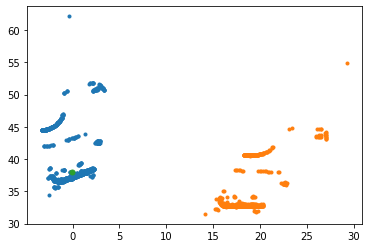

In [18]:
plt.plot(pointset[:,0],pointset[:,2],'.')
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
#plt.plot(pointset[seg,0],pointset[seg,2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)

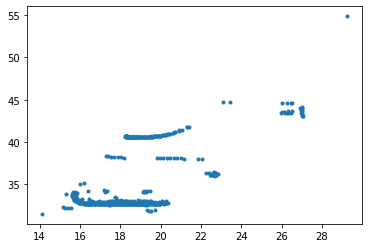

In [19]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')

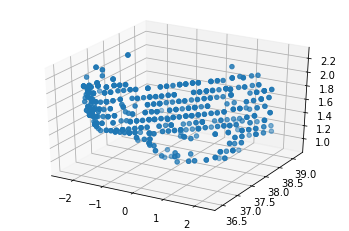

In [20]:
sel_pointset=pointset[seg,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(sel_pointset[:,0],sel_pointset[:,2],sel_pointset[:,1])

## See inference results

In [21]:
from config_tool import get_paths

import tensorflow as tf
import importlib
from train_util import get_batch
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
# Set training configurations
BATCH_SIZE = 32
MODEL_PATH = get_paths()[2]
GPU_INDEX = 0
MODEL = importlib.import_module("frustum_pointnets_v1")
NUM_CLASSES = 2
NUM_CHANNEL = 4

In [28]:
# functions excerpted from frustum-pointnet test.py
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:' + str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape) - 1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape) - 1, keepdims=True)
    return probs


def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    #    assert pc.shape[0] % batch_size == 0
    num_batches = math.ceil(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, pc.shape[0])

        feed_dict = { \
            ops['pointclouds_pl']: pc[start_idx:end_idx, ...],
            ops['one_hot_vec_pl']: one_hot_vec[start_idx:end_idx, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[start_idx:end_idx, ...] = batch_logits
        centers[start_idx:end_idx, ...] = batch_centers
        heading_logits[start_idx:end_idx, ...] = batch_heading_scores
        heading_residuals[start_idx:end_idx, ...] = batch_heading_residuals
        size_logits[start_idx:end_idx, ...] = batch_size_scores
        size_residuals[start_idx:end_idx, ...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:, :, 1]  # BxN
        batch_seg_mask = np.argmax(batch_logits, 2)  # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1)  # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,
        heading_prob = np.max(softmax(batch_heading_scores), 1)  # B
        size_prob = np.max(softmax(batch_size_scores), 1)  # B,
        # batch score includes the score of segmentation mask accuracy, heading, and size
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[start_idx:end_idx] = batch_scores
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [29]:
sess, ops = get_session_and_ops(batch_size=BATCH_SIZE, num_point=NUM_POINT)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from log_v1/model.ckpt


In [30]:
result_dir=None
TEST_DATASET=dataset

ps_list = []
seg_list = []
segp_list = []
center_list = []
heading_cls_list = []
heading_res_list = []
size_cls_list = []
size_res_list = []
rot_angle_list = []
score_list = []

test_idxs = np.arange(0, len(TEST_DATASET))
batch_size = BATCH_SIZE
num_batches = math.ceil(len(TEST_DATASET) / batch_size)
# assert ((len(TEST_DATASET) % int(batch_size)) == 0)

sess, ops = get_session_and_ops(batch_size=batch_size, num_point=NUM_POINT)
correct_cnt = 0
for batch_idx in range(num_batches):
    print('batch idx: %d' % (batch_idx))

    start_idx = batch_idx * batch_size
    end_idx = min(len(TEST_DATASET), (batch_idx + 1) * batch_size)
    print('start idx: {}, end idx: {}'.format(start_idx, end_idx))

    if (end_idx-start_idx)!=batch_size:
        sess, ops = get_session_and_ops(batch_size=(end_idx-start_idx), num_point=NUM_POINT)

    batch_data, batch_label, batch_center, \
    batch_hclass, batch_hres, batch_sclass, batch_sres, \
    batch_rot_angle, batch_one_hot_vec = \
        get_batch(TEST_DATASET, test_idxs, start_idx, end_idx,
                  NUM_POINT, NUM_CHANNEL)

    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
        inference(sess, ops, batch_data,
                  batch_one_hot_vec, batch_size=batch_size)

    correct_cnt += np.sum(batch_output == batch_label)

    for i in range(batch_output.shape[0]):
        ps_list.append(batch_data[i, ...])
        seg_list.append(batch_label[i, ...])
        segp_list.append(batch_output[i, ...])
        center_list.append(batch_center_pred[i, :])
        heading_cls_list.append(batch_hclass_pred[i])
        heading_res_list.append(batch_hres_pred[i])
        size_cls_list.append(batch_sclass_pred[i])
        size_res_list.append(batch_sres_pred[i, :])
        rot_angle_list.append(batch_rot_angle[i])
        score_list.append(batch_scores[i])

print("Segmentation accuracy: %f" % \
      (correct_cnt / float(batch_size * num_batches * NUM_POINT)))

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from log_v1/model.ckpt
batch idx: 0
start idx: 0, end idx: 32
batch idx: 1
start idx: 32, end idx: 36
INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summa

In [31]:
len(TEST_DATASET)

36

In [32]:
score_list[0]

-0.6984576224842785

In [33]:
segp_list[0]

array([1, 1, 1, ..., 1, 0, 0])

In [34]:
seg_list[0]

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

## Check the results

In [35]:
data_idx=1
np.sum(seg_list[data_idx]==segp_list[data_idx])/seg_list[data_idx].shape

array([0.94042969])

In [36]:
np.sum(seg_list[data_idx])

624

In [37]:
np.sum(segp_list[data_idx])

671

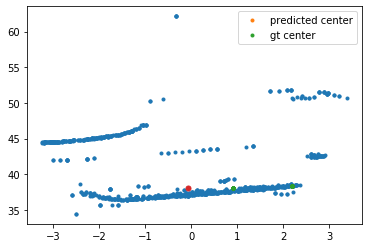

In [38]:
pointset=ps_list[data_idx]
box3d_center=dataset[data_idx][2]
plt.plot(pointset[:,0],pointset[:,2],'.')
#plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(pointset[segp_list[data_idx],0],pointset[segp_list[data_idx],2],'.',label='predicted center')
plt.plot(pointset[seg_list[data_idx],0],pointset[seg_list[data_idx],2],'.',label='gt center')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
plt.legend()
#plt.ylim([4,6])
#plt.xlim([-1,1])

## compare center

predicted center coordinate

In [39]:
pred_center=center_list[data_idx]
pred_center

array([ 0.26675504,  1.58572376, 38.25266647])

gt center coordinate

In [40]:
gt_center=dataset[data_idx][2]
gt_center

array([-0.07563623,  1.5687262 , 38.0366682 ])

### Convert center back to the world coordinates

In [41]:
rot_angle=dataset[data_idx][7]

In [42]:
gt_center

array([-0.07563623,  1.5687262 , 38.0366682 ])

In [43]:
gt_center_before_rotation=rotate_pc_along_y(np.expand_dims(gt_center,0),rot_angle=-rot_angle).squeeze()
gt_center_before_rotation

array([17.99118534,  1.5687262 , 33.51284975])

In [44]:
rotate_pc_along_y(np.expand_dims(gt_center_before_rotation,0),rot_angle=rot_angle).squeeze()

array([-0.07563623,  1.5687262 , 38.0366682 ])

In [45]:
gt_center_before_rotation

array([17.99118534,  1.5687262 , 33.51284975])

## compare heading

In [46]:
heading_cls_list[data_idx]

5

In [47]:
heading_res_list[data_idx]

-0.007138856220990419

### predicted heading angle

in radius

In [48]:
from provider import class2angle
pred_angle_radius=class2angle(heading_cls_list[data_idx],heading_res_list[data_idx],NUM_HEADING_BIN)
pred_angle_radius

2.6108550217705035

in degree

In [49]:
pred_angle_degree=pred_angle_radius*180/np.pi
pred_angle_degree

149.5909736679865

In [50]:
## Plus rotation angle

In [51]:
pred_angle_radius=class2angle(heading_cls_list[data_idx],
                              heading_res_list[data_idx],NUM_HEADING_BIN)+dataset[data_idx][7]
pred_angle_radius

3.1055303880662732

In [52]:
dataset[data_idx][3]

5

In [53]:
dataset.id_list[data_idx]

6

### heading angle ground truth:

In [54]:
gt_angle_radius=dataset.heading_list[data_idx]
gt_angle_radius

-3.129219460417827

In [55]:
gt_angle_degree=gt_angle_radius*180/np.pi
gt_angle_degree

-179.29106825214623

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3.,
         2.,  2.,  1.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,  5.]),
 array([-3.14048122e+00, -3.01490476e+00, -2.88932829e+00, -2.76375182e+00,
        -2.63817536e+00, -2.51259889e+00, -2.38702242e+00, -2.26144595e+00,
        -2.13586949e+00, -2.01029302e+00, -1.88471655e+00, -1.75914009e+00,
        -1.63356362e+00, -1.50798715e+00, -1.38241069e+00, -1.25683422e+00,
        -1.13125775e+00, -1.00568129e+00, -8.80104820e-01, -7.54528353e-01,
        -6.28951886e-01, -5.03375419e-01, -3.77798952e-01, -2.52222486e-01,
        -1.26646019e-01, -1.06955185e-03,  1.24506915e-01,  2.50083382e-01,
         3.75659849e-01,  5.01236315e-01,  6.26812782e-01,  7.52389249e-01,
         8.77965716e-01,  1.00354218e+00,  1.12911865e+00,  1.25469512e+00,
         1.38027158e+00,  1.5058

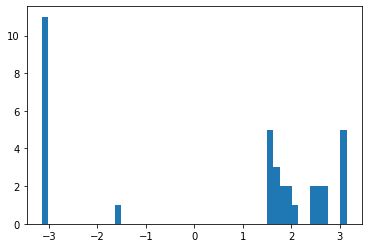

In [56]:
plt.hist(dataset.heading_list,bins=50)

## Compare all heading angles

In [ ]:
type(heading_cls_list)

In [ ]:
all_pred_angle_radius=np.empty(len(heading_cls_list))
for idx in range(len(heading_cls_list)):
    pred_angle_radius=class2angle(heading_cls_list[idx],heading_res_list[idx],NUM_HEADING_BIN)+dataset[idx][7]
    all_pred_angle_radius[idx]=pred_angle_radius

In [ ]:
all_gt_angle_raidus=np.array(dataset.heading_list)

In [ ]:
## plot in 2D
plt.plot(all_gt_angle_raidus,all_pred_angle_radius,'.')
plt.xlabel("ground truth heading angle")
plt.ylabel("predicted heading angle")

It seems the heading angle is of some classes are not correct.

## Compare box

In [ ]:
from provider import class2size

predicted box size

In [ ]:
class2size(size_cls_list[data_idx],size_res_list[data_idx])

ground truth of box size

In [ ]:
dataset.size_list[data_idx]

## Convert the prediction back to world coordinates

extract the token

In [ ]:
train_df=parse_train_csv()

In [ ]:
train_df.head(1)

In [ ]:
sample_token=train_df.iloc[data_idx,0]
sample_token

### Convert ground truth box back to world coordiantes

In [ ]:
gt_angle

In [ ]:
gt_size=dataset.size_list[data_idx]
gt_angle=dataset.heading_list[data_idx]
l,w,h=gt_size

first_rot=Quaternion(axis=[1,0,0],angle=np.pi/2)
second_rot=Quaternion(axis=[0,-1,0],angle=-gt_angle)
gt_box_in_sensor_coord=Box(center=gt_center_before_rotation,size=[w,l,h],
                             orientation=second_rot*first_rot)


#gt_box_in_sensor_coord.rotate(third_rot)

In [ ]:
gt_box_in_sensor_coord

In [ ]:
cam_to_world_mtx=get_sensor_to_world_transform_matrix(sensor_type='CAM_FRONT',
                                                      sample_token=train_df.iloc[dataset.id_list[data_idx],0])

In [ ]:
gt_center_before_rotation_h=np.concatenate((gt_center_before_rotation,np.ones(1)))
gt_center_before_rotation_h

In [ ]:
np.dot(cam_to_world_mtx,np.transpose(gt_center_before_rotation_h))

In [ ]:
gt_box_in_sensor_coord

In [ ]:
gt_box_in_sensor_coord_corners=gt_box_in_sensor_coord.corners()
gt_box_in_sensor_coord_corners
print(gt_box_in_sensor_coord_corners.shape)

In [ ]:
gt_box_in_sensor_coord_corners_h=np.concatenate((gt_box_in_sensor_coord_corners,np.ones((1,8))),axis=0)
gt_box_in_sensor_coord_corners_h.shape

In [ ]:
corners_in_world_coord=np.dot(cam_to_world_mtx,gt_box_in_sensor_coord_corners_h)
corners_in_world_coord

In [ ]:
gt_box_in_world_coord=convert_box_to_world_coord(gt_box_in_sensor_coord,
                                                 sensor_type='CAM_FRONT',sample_token=train_df.iloc[data_idx,0])
gt_box_in_world_coord

In [ ]:
gt_box_in_world_coord.orientation.yaw_pitch_roll

In [ ]:
get_box_yaw_angle_in_world_coords(gt_box_in_world_coord)+np.pi

In [ ]:
_,gt_box=get_train_data_sample_token_and_box(dataset.id_list[data_idx],train_df)
gt_box

In [ ]:
fig,ax=plt.subplots()
view_mtx=np.eye(2)
gt_box.render(ax,view=view_mtx)
gt_box_in_world_coord.render(ax,view=view_mtx)

In [ ]:
fig,ax=plt.subplots()
view_mtx=np.array([[0,1,0],[0,0,1],[0,0,0]])
gt_box.render(ax,view=view_mtx)
gt_box_in_world_coord.render(ax,view=view_mtx)

In [ ]:
gt_box.corners()

In [ ]:
gt_box_in_world_coord.corners()

In [ ]:
get_box_yaw_angle_in_world_coords(gt_box_in_world_coord)

In [ ]:
from prepare_lyft_data import get_box_corners_yaw_angle_in_world_coords
get_box_corners_yaw_angle_in_world_coords(corners_in_world_coord[0:3,:])

### Convert predicted box back to world coordinates

In [ ]:
pred_size=class2size(size_cls_list[data_idx],size_res_list[data_idx])
center=np.array(center_list[data_idx])
rotated_back_center=rotate_pc_along_y(np.expand_dims(center,0),-rot_angle).squeeze()
l,w,h=class2size(size_cls_list[data_idx],size_res_list[data_idx])
pred_angle_radius=class2angle(heading_cls_list[data_idx],
                              heading_res_list[data_idx],NUM_HEADING_BIN)+dataset[data_idx][7]
pred_box_in_sensor_coord=Box(center=rotated_back_center,size=[h,l,w],
                             orientation=Quaternion(axis=[0,-1,0],angle=pred_angle_radius+np.pi))

In [ ]:
center

In [ ]:
box_in_world_coord=convert_box_to_world_coord(pred_box_in_sensor_coord,
                           sensor_type='CAM_FRONT',sample_token=train_df.iloc[data_idx,0])
box_in_world_coord

In [ ]:
train_df.iloc[data_idx,:]

Calculate the yaw angle in world coordinates

In [ ]:
get_box_yaw_angle_in_world_coords(box_in_world_coord)